This notebook implements a simple MLP for MNIST classification

**Objectives**:
* Try out pytorch basics
* Get a feel for training NN
* Feel good about high accuracy

In [1]:
import sys
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt

In [2]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)

System Version: 3.13.0rc3 (main, Oct 30 2024, 17:56:08) [Clang 15.0.0 (clang-1500.3.9.4)]
PyTorch version 2.6.0
Torchvision version 0.21.0
Numpy version 2.2.4


100.0%
100.0%
100.0%
100.0%


60000


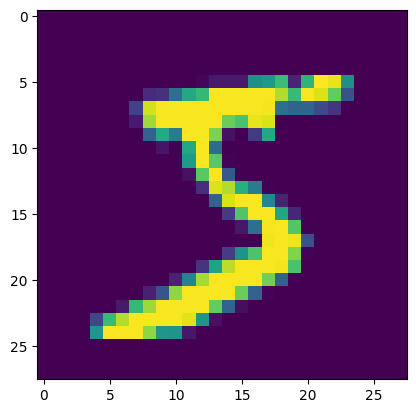

In [3]:
# load dataset and show image
train_dataset = datasets.MNIST(root='/tmp', train=True, download=True, transform=transforms.ToTensor())
print(len(train_dataset))
plt.imshow(np.transpose(train_dataset[0][0].numpy(), (1, 2, 0)))

In [8]:
# split train,val sets
val_size = 0.2
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(val_size * num_train))
batch_size = 64

np.random.seed(3)
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

len(train_loader), len(val_loader)

(750, 188)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

labels: tensor([8, 0, 6, 4])
batch shape: torch.Size([64, 1, 28, 28])


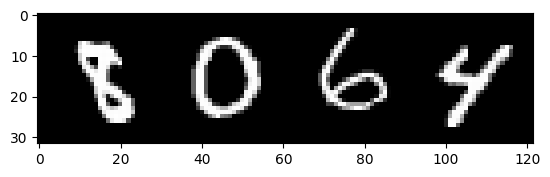

In [9]:
# show part of batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"labels: {labels[:4]}")
print(f"batch shape: {images.size()}")
im = torchvision.utils.make_grid(images[:4])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [6]:
# load test set
test_dataset = datasets.MNIST(root='/tmp', train=False, download=True, transform=transforms.ToTensor())
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

10000


In [4]:
# select device and 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
# Build the model
class MnistClassifier(nn.Module):
    def __init__(self):
        super(MnistClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits

model = MnistClassifier()
model.to(device)
print(model)

MnistClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [9]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

output: [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
predicted label: 0 actual label: 0


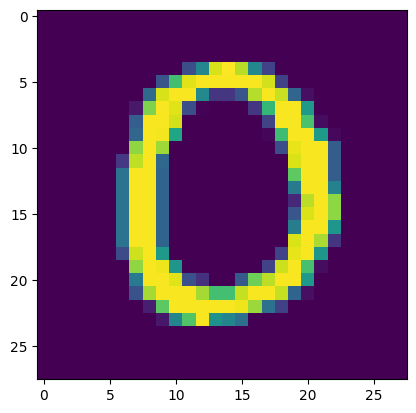

In [10]:
# inference with untrained model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten().round(decimals=4) * 100

predictions = predict(model, images[1], device)
pred_label = predictions.argmax()
print(f"output: {predictions}")
print(f"predicted label: {pred_label} actual label: {labels[1]}")
plt.imshow(np.transpose(images[1].cpu().numpy(), (1, 2, 0)))

In [11]:
# train validate loop
num_epochs = 30
train_size = len(train_loader)*batch_size
val_size = len(val_loader)*batch_size
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for n in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0

    # train
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # predict
        output = model(images)
        loss = loss_fn(output, labels)

        # backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item() * labels.size(0)
        correct += (output.argmax(1) == labels).type(torch.float).sum().item()
    train_loss = running_loss / train_size
    train_accuracy = 100 * correct / train_size
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # validate
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # predict
            output = model(images)
            loss = loss_fn(output, labels)
            running_loss += loss.item() * labels.size(0)
            correct += (output.argmax(1) == labels).type(torch.float).sum().item()
    val_loss = running_loss / val_size  
    val_accuracy = 100 * correct / val_size
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch: {n+1}/{num_epochs} - Train loss: {train_loss:>8f}, Train accuracy: {train_accuracy:>0.1f}%, Validation Loss: {val_loss:>8f}, Accuracy: {val_accuracy:>0.1f}%")

Epoch: 1/30 - Train loss: 0.337929, Train accuracy: 90.7%, Validation Loss: 0.183028, Accuracy: 94.3%
Epoch: 2/30 - Train loss: 0.144403, Train accuracy: 95.8%, Validation Loss: 0.128370, Accuracy: 95.9%
Epoch: 3/30 - Train loss: 0.096302, Train accuracy: 97.2%, Validation Loss: 0.098771, Accuracy: 96.8%
Epoch: 4/30 - Train loss: 0.068661, Train accuracy: 98.0%, Validation Loss: 0.101329, Accuracy: 96.7%
Epoch: 5/30 - Train loss: 0.051821, Train accuracy: 98.4%, Validation Loss: 0.087587, Accuracy: 97.0%
Epoch: 6/30 - Train loss: 0.039000, Train accuracy: 98.8%, Validation Loss: 0.085390, Accuracy: 97.2%
Epoch: 7/30 - Train loss: 0.030174, Train accuracy: 99.1%, Validation Loss: 0.084245, Accuracy: 97.1%
Epoch: 8/30 - Train loss: 0.021429, Train accuracy: 99.4%, Validation Loss: 0.086182, Accuracy: 97.3%
Epoch: 9/30 - Train loss: 0.017707, Train accuracy: 99.5%, Validation Loss: 0.082643, Accuracy: 97.3%
Epoch: 10/30 - Train loss: 0.013835, Train accuracy: 99.6%, Validation Loss: 0.084

KeyboardInterrupt: 

In [12]:
# test
model.eval()
running_loss, correct = 0.0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # predict
        output = model(images)
        loss = loss_fn(output, labels)
        running_loss += loss.item() * labels.size(0)
        correct += (output.argmax(1) == labels).type(torch.float).sum().item()
test_loss = running_loss / len(test_loader.dataset)     
test_accuracy = 100 * correct / len(test_loader.dataset)

print(f"Test loss: {test_loss}, Test Accuracy: {test_accuracy:>0.1f}")

Test loss: 0.08882159288861512, Test Accuracy: 98.0


In [13]:
# save model
torch.save(model.state_dict(), '/kaggle/working/mnistclassifier-1l256-adam-0001-20epoch.pth')

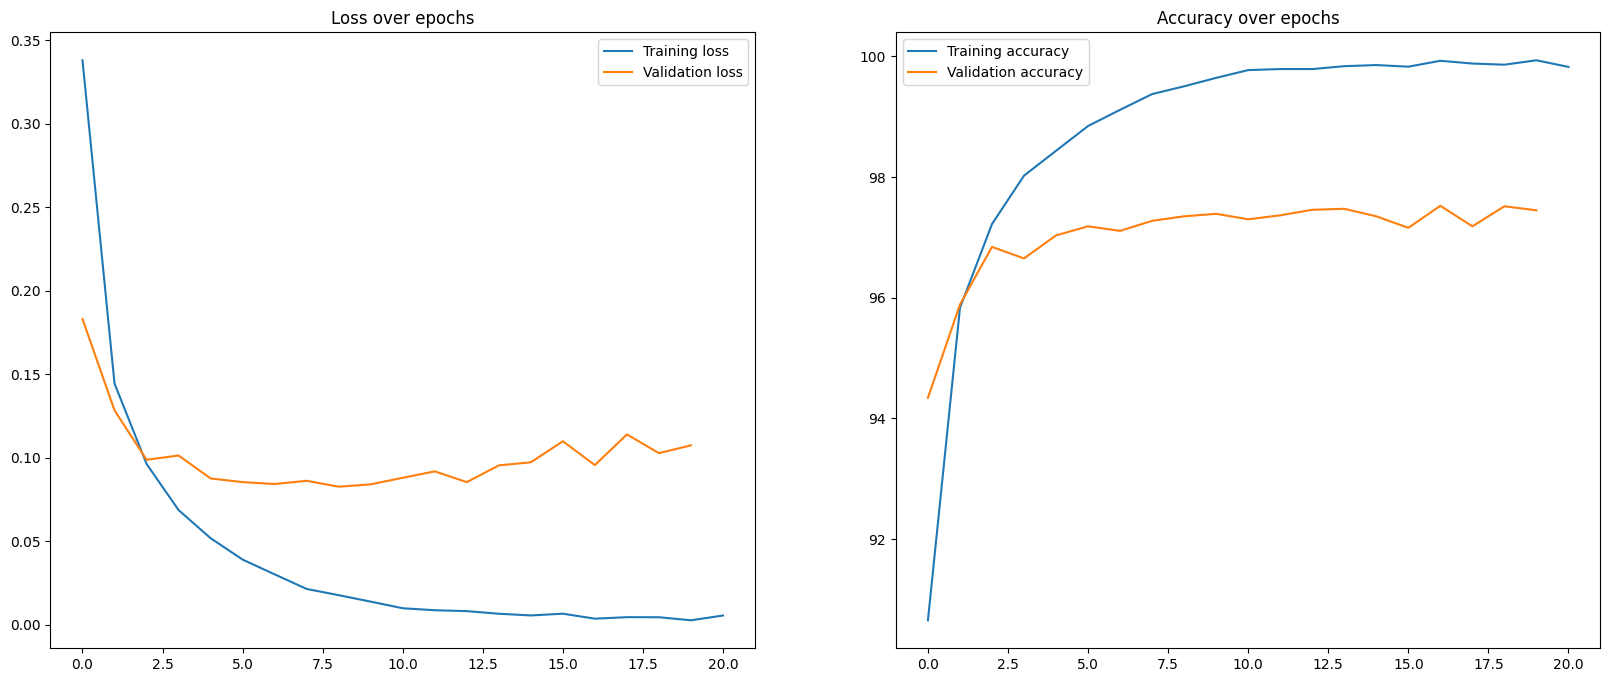

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.legend()
ax1.set_title("Loss over epochs")

ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(val_accuracies, label='Validation accuracy')
ax2.legend()
ax2.set_title("Accuracy over epochs")
fig.show()

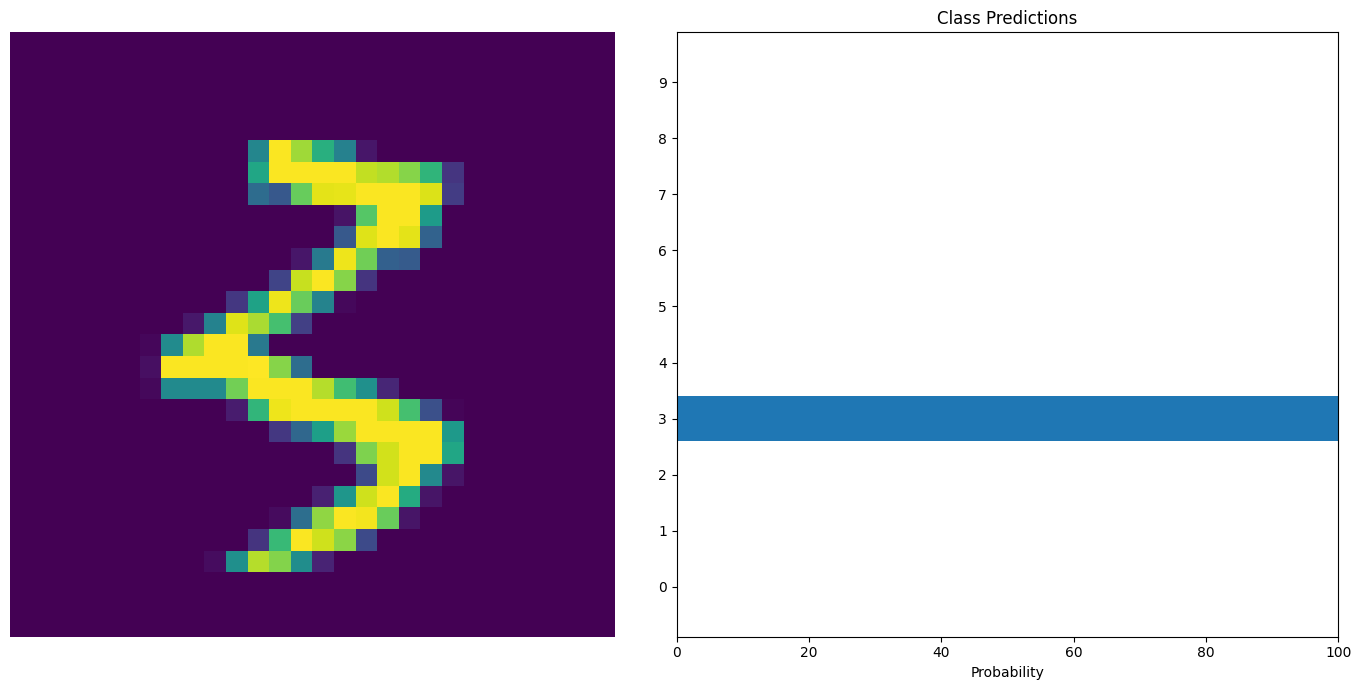

In [12]:
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 100)

    plt.tight_layout()
    plt.show()

class_names = ['0','1','2','3','4','5','6','7','8','9']

idx = np.random.randint(batch_size)
testiter = iter(train_loader)
test_images, test_labels = next(testiter)
image_tensor = np.transpose(test_images[idx].cpu().numpy(), (1, 2, 0))
predictions = predict(model, test_images[idx], device)
visualize_predictions(image_tensor, predictions, class_names)

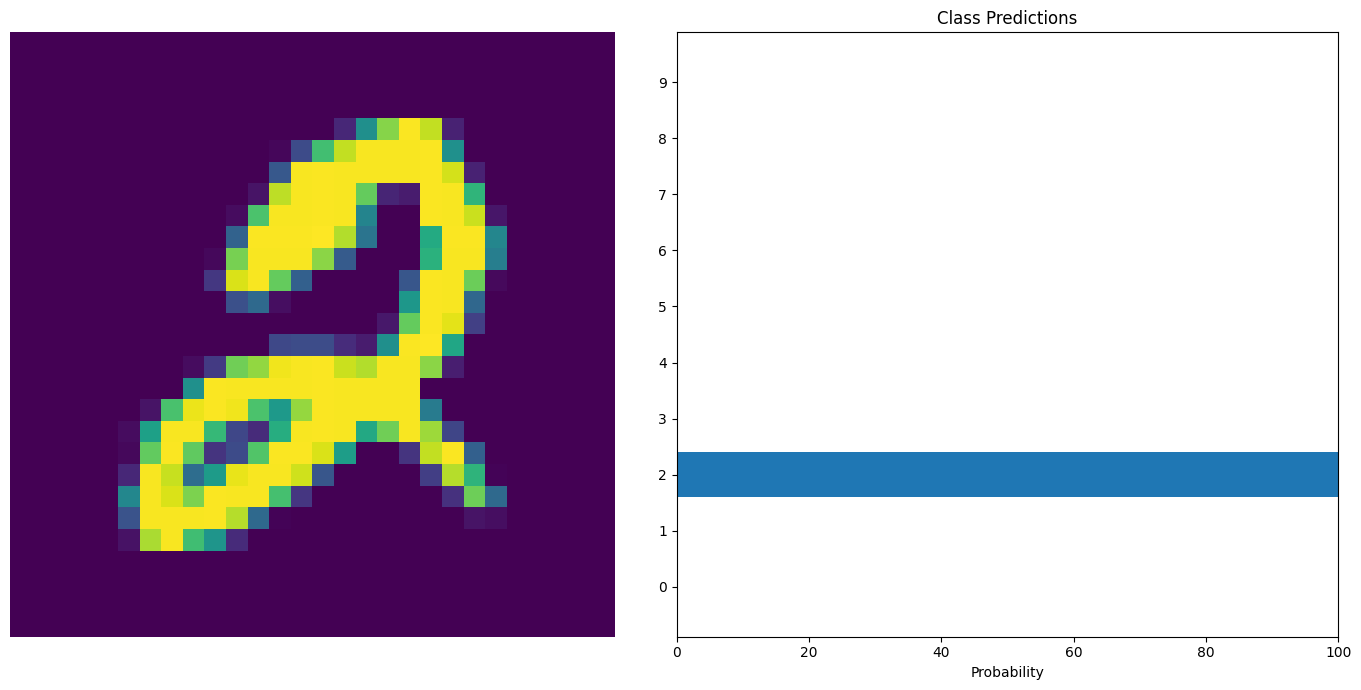

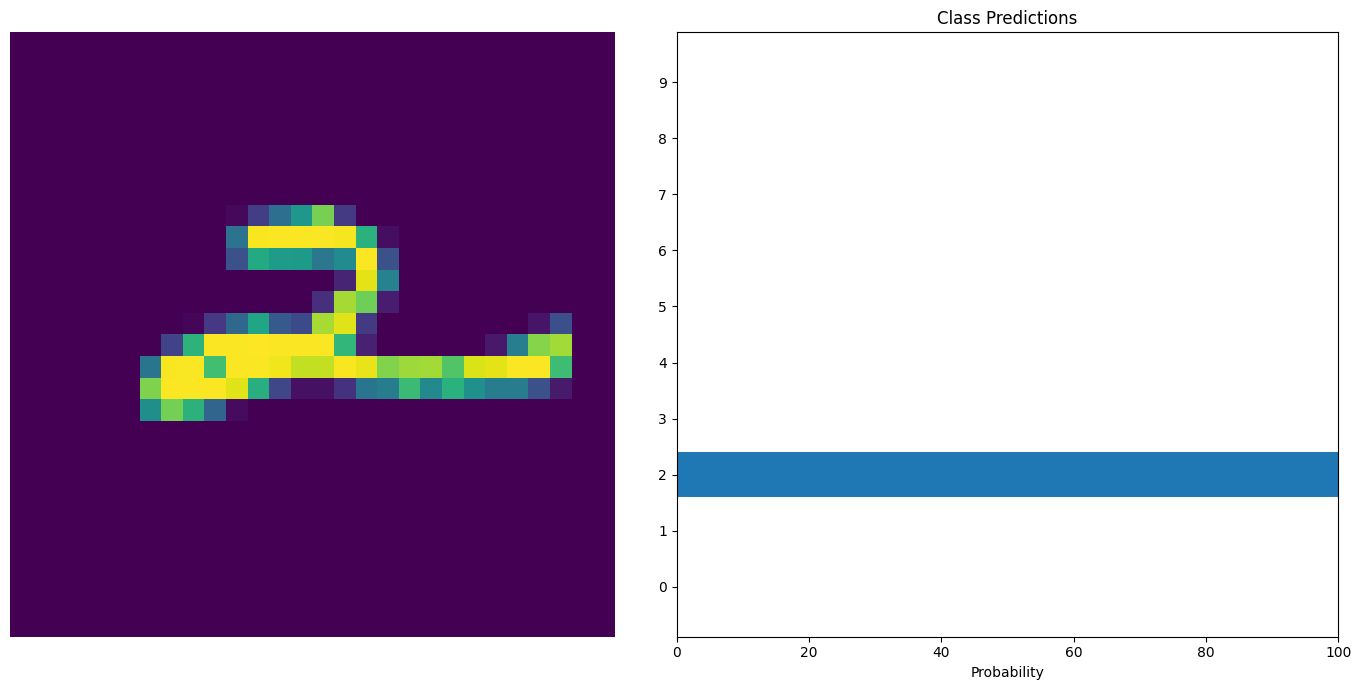

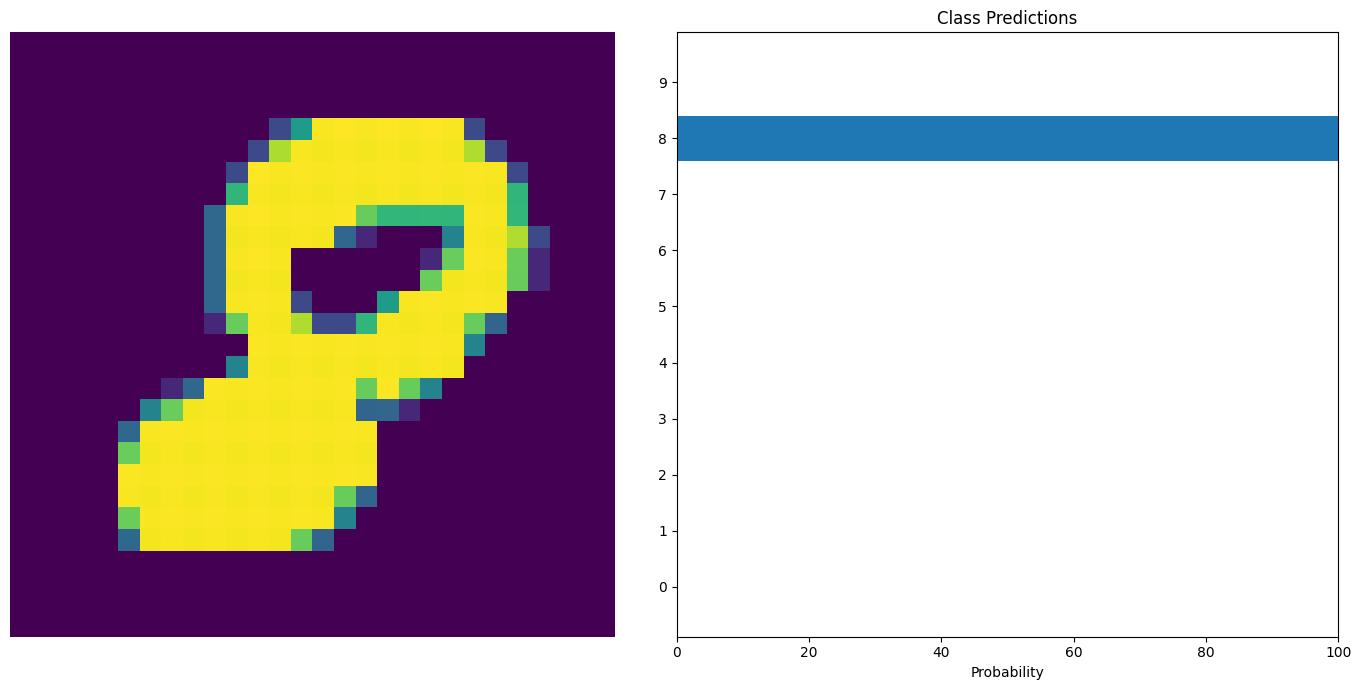

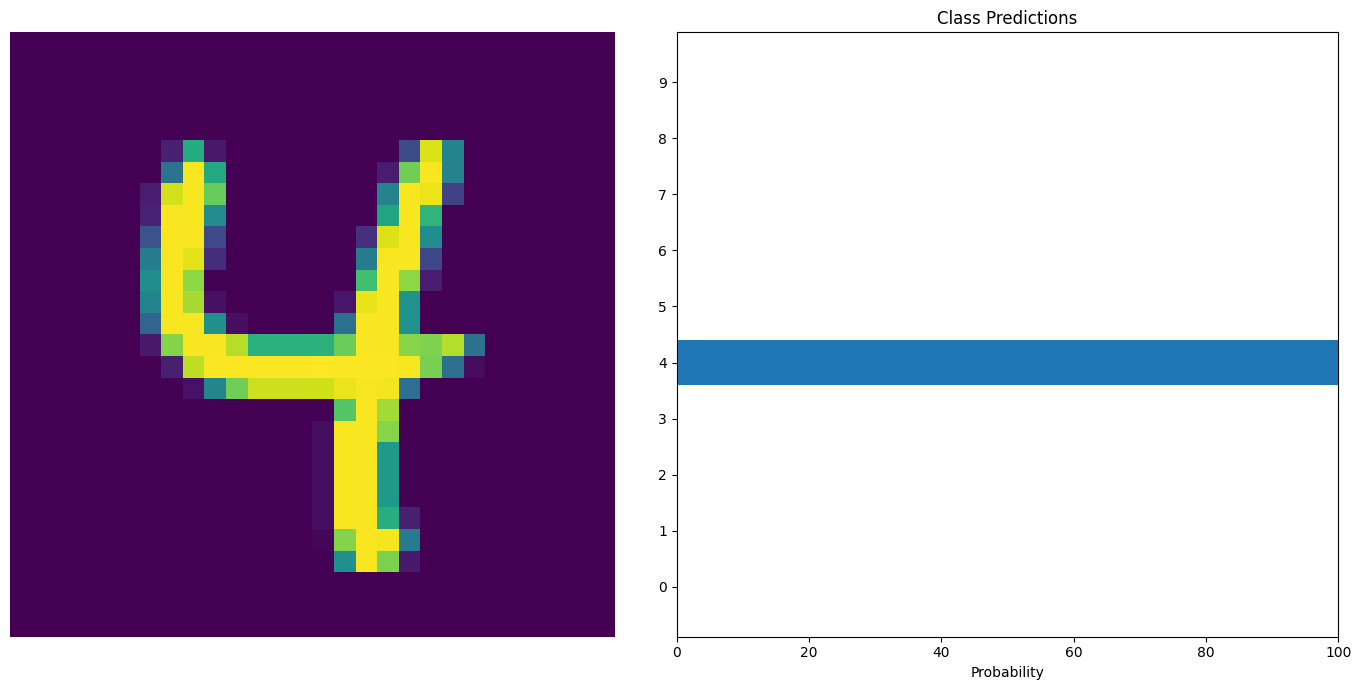

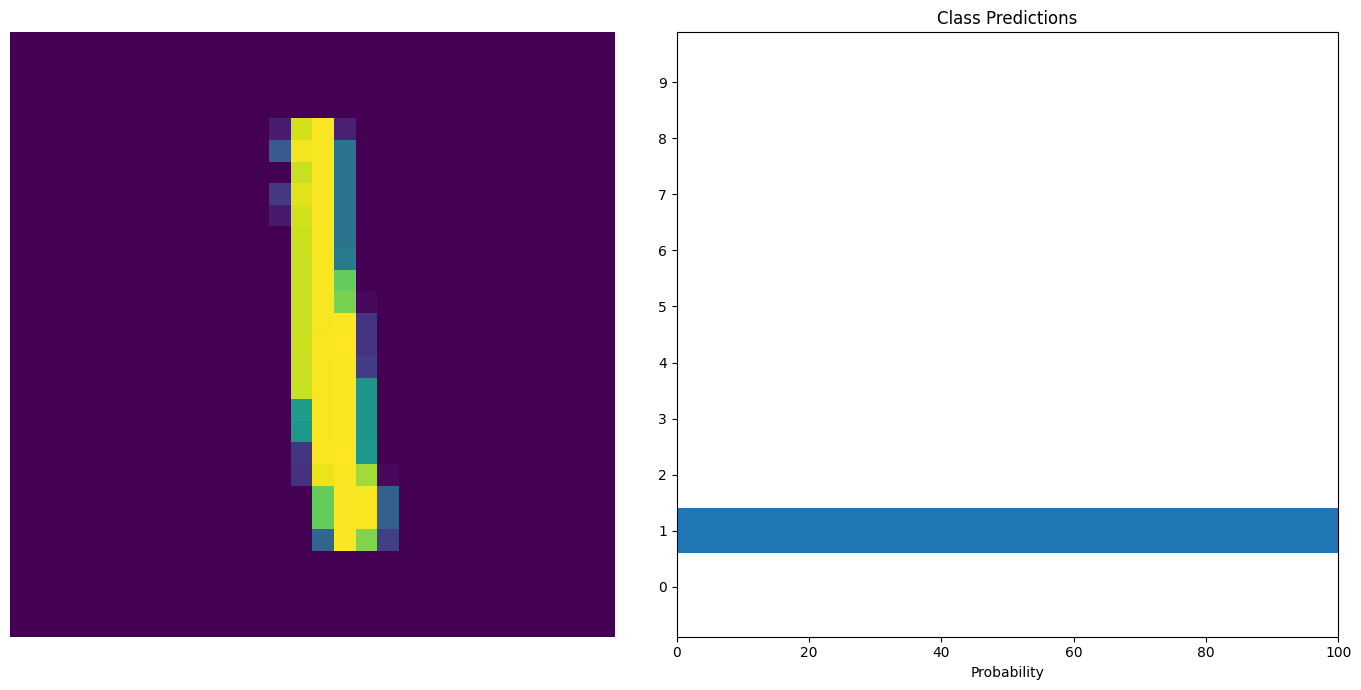

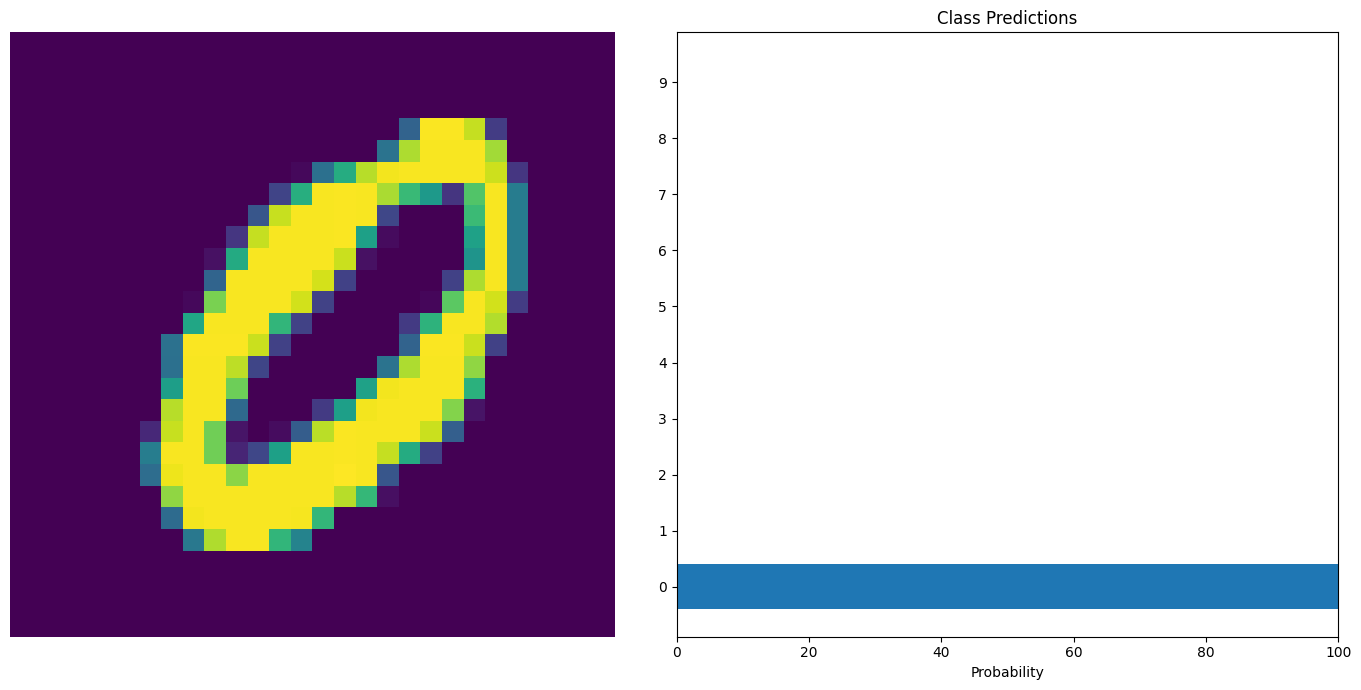

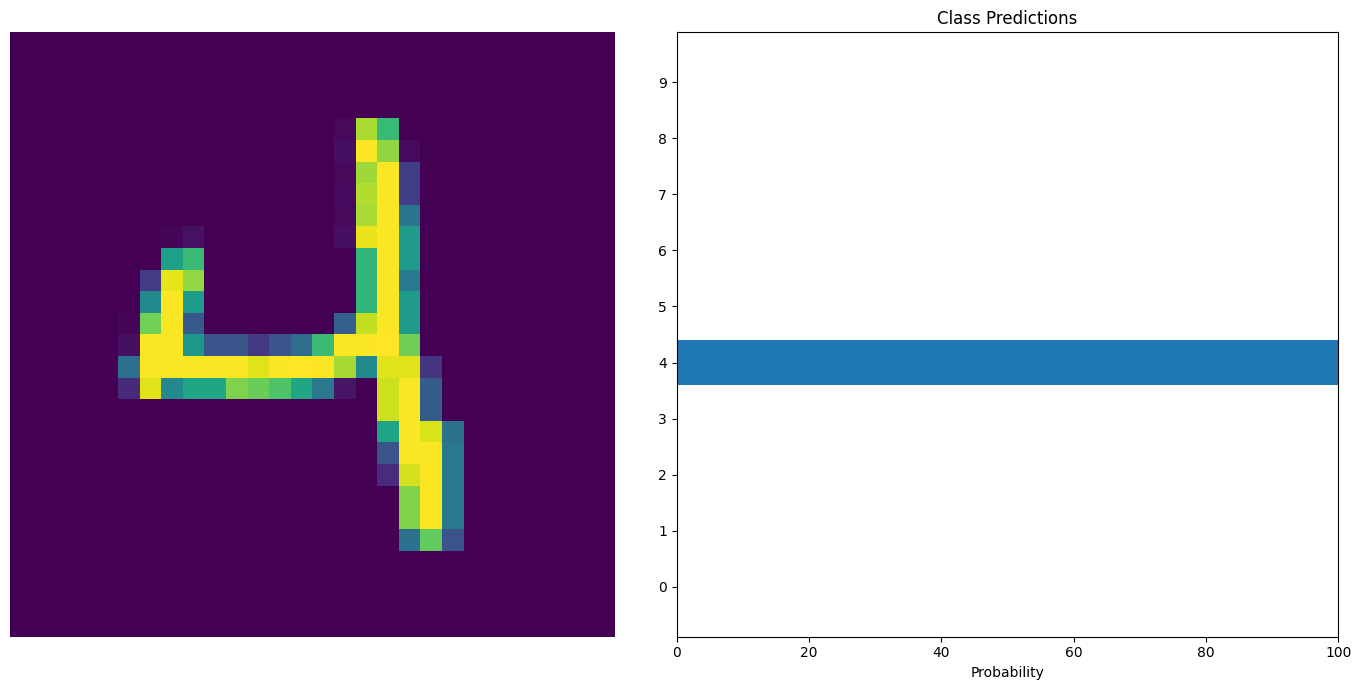

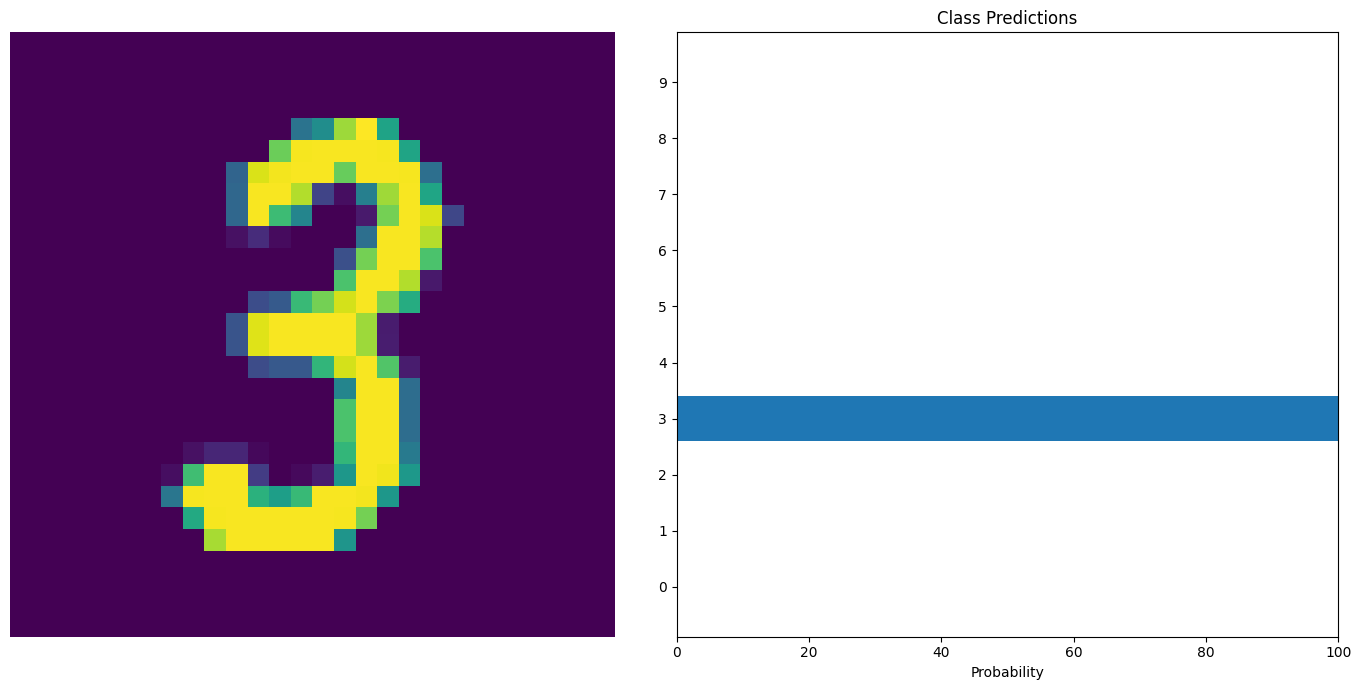

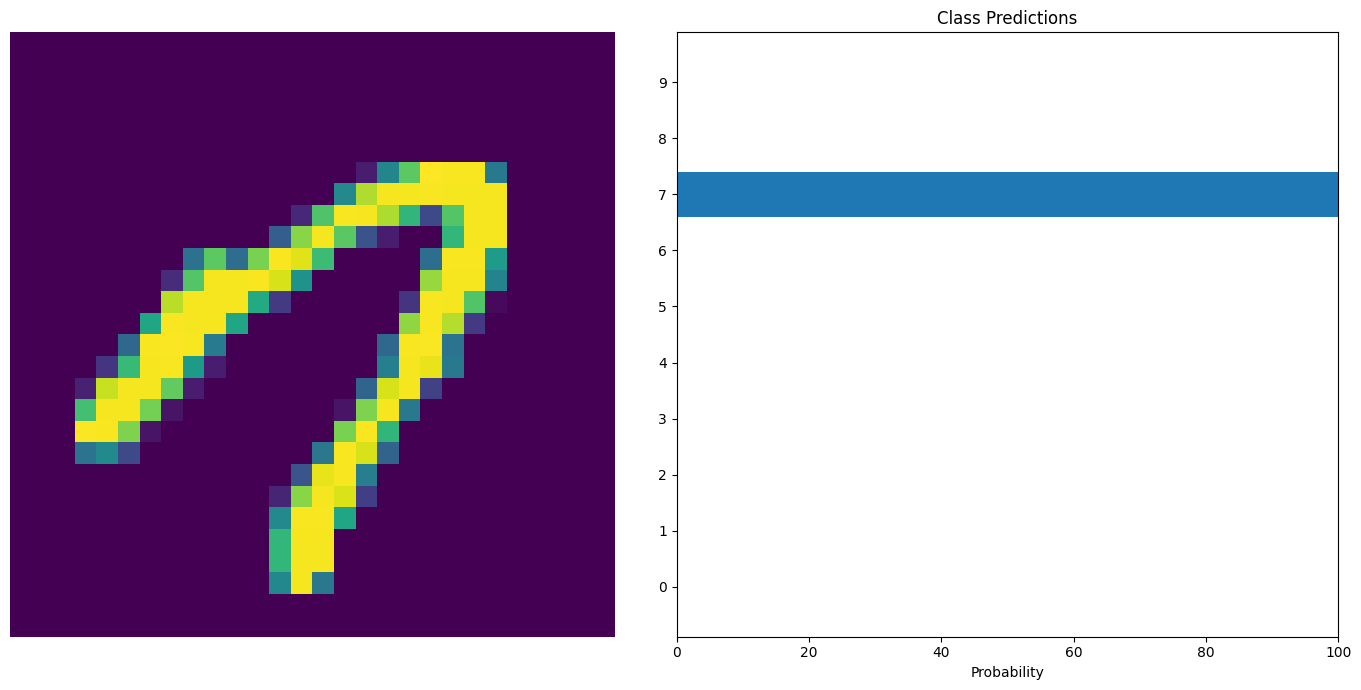

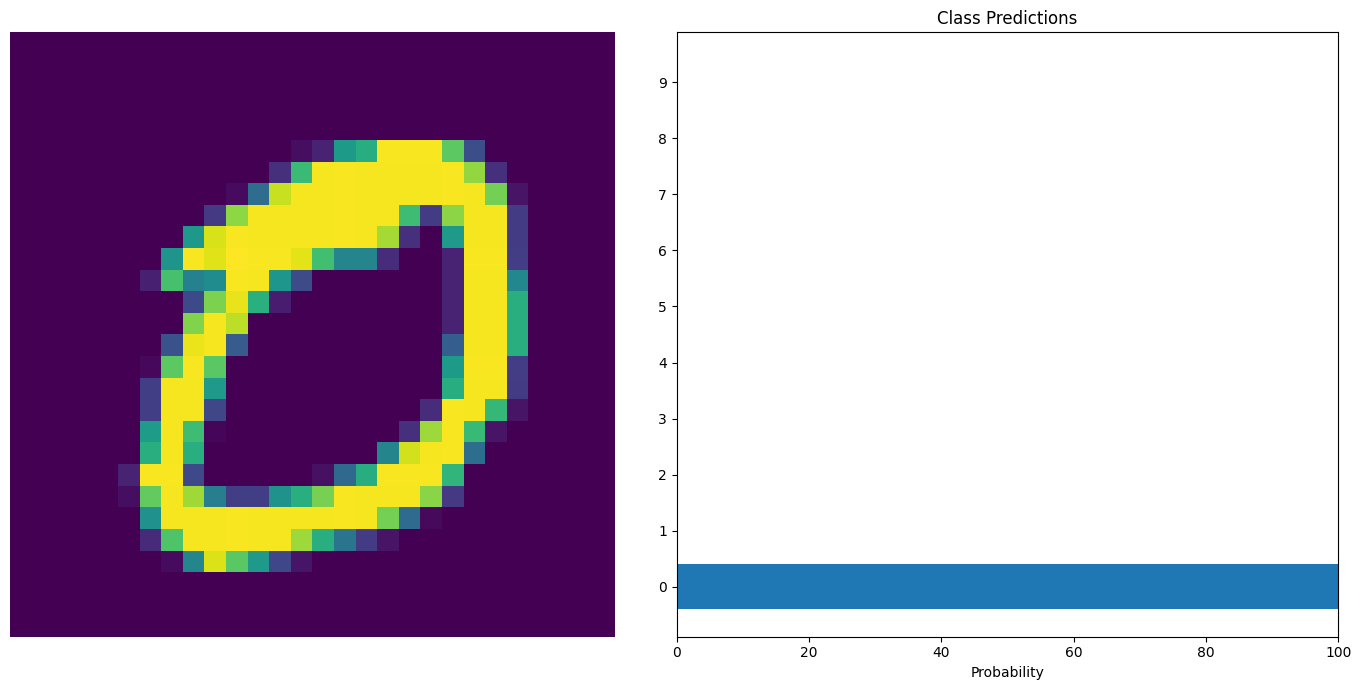

In [17]:
for i in range(10):
    image_tensor = np.transpose(test_images[i].cpu().numpy(), (1, 2, 0))
    predictions = predict(model, test_images[i], device)
    visualize_predictions(image_tensor, predictions, class_names)

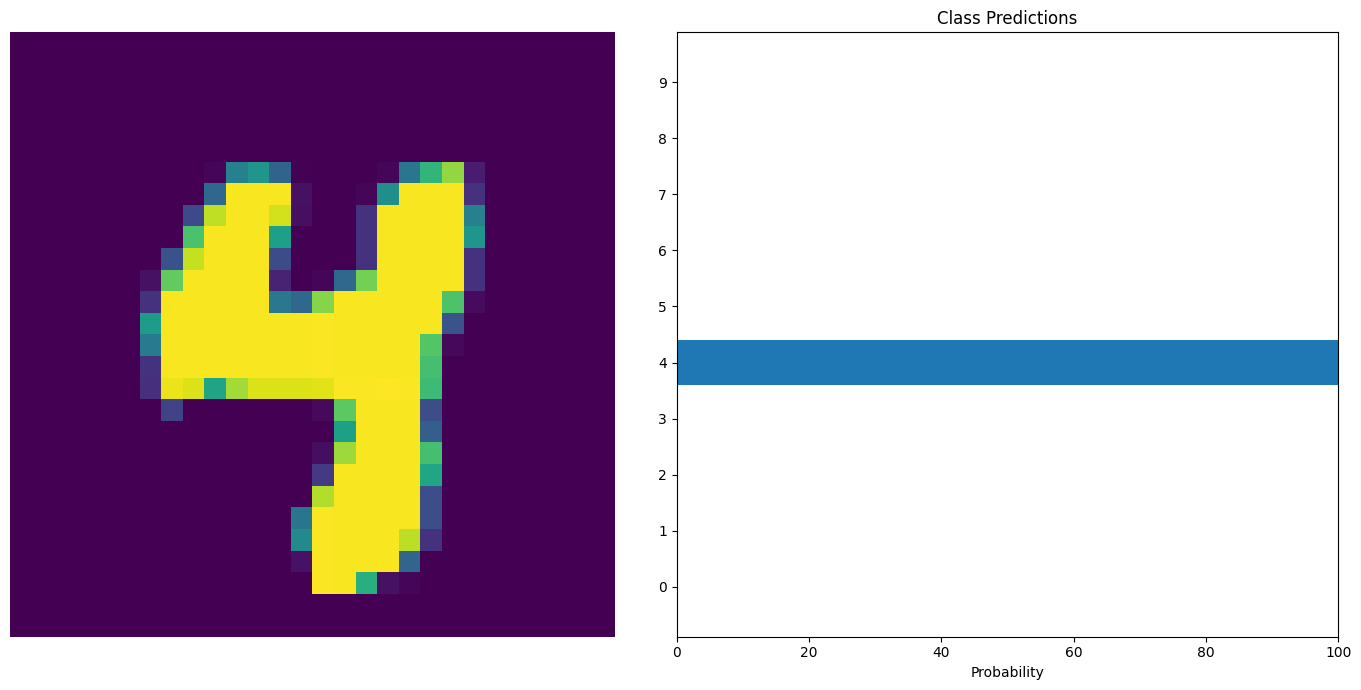

In [14]:
# load model
model = MnistClassifier()
model.load_state_dict(torch.load('mnistclassifier-1l256-adam-0001-20epoch.pth', map_location=device))
model.eval()
# load test set
test_dataset = datasets.MNIST(root='/tmp', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# test
model.eval()
# test one random image
idx = np.random.randint(batch_size)
testiter = iter(test_loader)
test_images, test_labels = next(testiter)
image_tensor = test_images[idx].to(device)
predictions = predict(model, image_tensor, device)
visualize_predictions(np.transpose(test_images[idx].cpu().numpy(), (1, 2, 0)), predictions, class_names)